# Baseline Model

Before model selection a simpel model must be run to act as a baseline for compaison of model performance. For this baseline we will use a simple Random Forest Regressor to predic the Mid-Price in 20 ticks time. 

The baseline model will be trained using a simple featureset consiting solely of data from the first level of the Limit Order Book.

### Import Libraries

In [1]:
#import required libraries
# from utils import aws # used to create aws session and load parquet 
import pandas as pd
import numpy as np
# import ast 
# import dask.dataframe as dd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
import xgboost as xgb

import matplotlib.pyplot as plt
import datetime

### Load Dataset

Currently this is run using the sample dataset, but going forward will need to be run using the full LOB dataset.

In [2]:
#load sample feature set from s3 to a dask dataframe
# samp_lob_ddf = aws.load_s3_file_as_ddf("s3://dsmp-ol2/processed-data/temp_sample_lob_feature_set.parquet")

In [3]:
#compute the dask datafram to a pandas dataframe
# df = samp_lob_ddf.compute()
df = pd.read_csv("data/full_lob_head.csv", index_col=0)
df

,Timestamp,Exchange,Order Type,Price,Quantity,Date
25781997,0.000,Exch0,Bid,NaN,NaN,2025-01-02
67020690,0.000,Exch0,Ask,NaN,NaN,2025-01-02
25781998,0.279,Exch0,Bid,1.0,6.0,2025-01-02
67020691,0.279,Exch0,Ask,NaN,NaN,2025-01-02
25781999,1.333,Exch0,Bid,1.0,6.0,2025-01-02
...,...,...,...,...,...,...
26123018,29573.938,Exch0,Bid,292.0,2.0,2025-01-02
26123018,29573.938,Exch0,Bid,291.0,9.0,2025-01-02
26123018,29573.938,Exch0,Bid,288.0,3.0,2025-01-02
26123018,29573.938,Exch0,Bid,287.0,4.0,2025-01-02


In [4]:
# 1. Filter out rows with NaN values in 'Price' and 'Quantity'
df_filtered = df.dropna(subset=['Price', 'Quantity'])

# 2. Calculate the best bid and ask prices and volumes
best_bids = df_filtered[df_filtered['Order Type'] == 'Bid'].groupby('Timestamp').agg({'Price': 'max', 'Quantity': 'sum'}).rename(columns={'Price': 'Best Bid Price', 'Quantity': 'Bid Volume at Level 1'})
best_asks = df_filtered[df_filtered['Order Type'] == 'Ask'].groupby('Timestamp').agg({'Price': 'min', 'Quantity': 'sum'}).rename(columns={'Price': 'Best Ask Price', 'Quantity': 'Ask Volume at Level 1'})

# 3. Merge best bids and asks to calculate mid-price and spread
df_merged = best_bids.merge(best_asks, left_index=True, right_index=True, how='outer')
df_merged['Mid-price'] = (df_merged['Best Bid Price'] + df_merged['Best Ask Price']) / 2
df_merged['Bid-Ask Spread'] = df_merged['Best Ask Price'] - df_merged['Best Bid Price']

# 4. Calculate order imbalance at level 1
df_merged['Order Imbalance Level 1'] = df_merged['Bid Volume at Level 1'] - df_merged['Ask Volume at Level 1']

# Merging the features back with the original DataFrame
df = df.merge(df_merged, left_on='Timestamp', right_index=True, how='left')

df

,Timestamp,Exchange,Order Type,Price,Quantity,Date,Best Bid Price,Bid Volume at Level 1,Best Ask Price,Ask Volume at Level 1,Mid-price,Bid-Ask Spread,Order Imbalance Level 1
25781997,0.000,Exch0,Bid,NaN,NaN,2025-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67020690,0.000,Exch0,Ask,NaN,NaN,2025-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25781998,0.279,Exch0,Bid,1.0,6.0,2025-01-02,1.0,6.0,NaN,NaN,NaN,NaN,NaN
67020691,0.279,Exch0,Ask,NaN,NaN,2025-01-02,1.0,6.0,NaN,NaN,NaN,NaN,NaN
25781999,1.333,Exch0,Bid,1.0,6.0,2025-01-02,1.0,6.0,800.0,1.0,400.5,799.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
26123018,29573.938,Exch0,Bid,292.0,2.0,2025-01-02,295.0,20.0,NaN,NaN,NaN,NaN,NaN
26123018,29573.938,Exch0,Bid,291.0,9.0,2025-01-02,295.0,20.0,NaN,NaN,NaN,NaN,NaN
26123018,29573.938,Exch0,Bid,288.0,3.0,2025-01-02,295.0,20.0,NaN,NaN,NaN,NaN,NaN
26123018,29573.938,Exch0,Bid,287.0,4.0,2025-01-02,295.0,20.0,NaN,NaN,NaN,NaN,NaN


### Create Target Column

The baseline model will be used to predict the future Mid-Price at a single horizon. 

#### Set the Horizon

In [5]:
# The horizon is how far in the future the Mid-Proce is being predicted
horizon = 20

In [6]:
df['Target'] = df['Mid-price'].shift(-horizon)

# Drop rows where all values in the 'Target' column are NaN
df.dropna(subset=['Target'], how='all', inplace=True)
df = df.drop(columns=['Timestamp','Date', 'Exchange','Order Type'])
df = df.dropna()
df

,Price,Quantity,Best Bid Price,Bid Volume at Level 1,Best Ask Price,Ask Volume at Level 1,Mid-price,Bid-Ask Spread,Order Imbalance Level 1,Target
25781999,1.0,6.0,1.0,6.0,800.0,1.0,400.5,799.0,5.0,279.0
67020692,800.0,1.0,1.0,6.0,800.0,1.0,400.5,799.0,5.0,279.5
25782000,1.0,6.0,1.0,6.0,799.0,1.0,400.0,798.0,5.0,279.5
67020693,799.0,1.0,1.0,6.0,799.0,1.0,400.0,798.0,5.0,279.5
25782001,1.0,6.0,1.0,6.0,798.0,1.0,399.5,797.0,5.0,279.5
...,...,...,...,...,...,...,...,...,...,...
26123016,239.0,5.0,295.0,41.0,303.0,14.0,299.0,8.0,27.0,299.0
26123016,235.0,10.0,295.0,41.0,303.0,14.0,299.0,8.0,27.0,299.0
26123016,220.0,3.0,295.0,41.0,303.0,14.0,299.0,8.0,27.0,299.0
26123016,93.0,2.0,295.0,41.0,303.0,14.0,299.0,8.0,27.0,299.0


Mean Squared Error: 40.40413349622838
Root Mean Squared Error: 6.356424584326348
R^2 Score: 0.8714770292215002


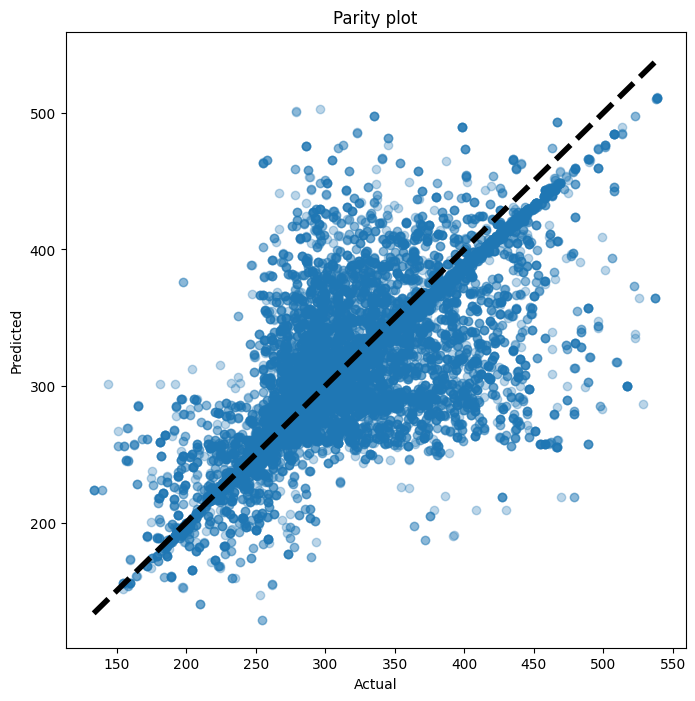

In [7]:
# Step 3: Splitting the dataset
X = df.drop(['Target'], axis=1)  # Features
y = df['Target']  # Target - Shift 'Mid_Price' by 20 timestamps into the future

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Normalizing/Standardizing the features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# Step 5: Model Selection
# model = RandomForestRegressor(n_estimators=100, random_state=42)

# from sklearn.svm import SVR

# model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

model = LinearRegression()

# Step 6: Training
model.fit(X_train, y_train)

# Step 7: Evaluation
y_pred = model.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Calculate Mean Squared Error
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

# Calculate R^2 Score
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2}')

# parity plot
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Parity plot')
# save plot 
plt.savefig(f'plots/parity_plot_baseline.png')

plt.show()